# Introduction

In this notebook, we will go through the process of cleaning data and training model to predict which passengers survived during the Titanic disaster. This dataset comes from Kaggle.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

# Data manipulation using pandas

## Loading the csv file

We load the csv file into a `pandas.DataFrame` using `pandas.read_csv`. Dataframe is a very convinient way to manipulate data as we will see below.

In [2]:
df = pd.read_csv('data/titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let's also look at the survivor repartition in the dataset.

In [4]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

## Data cleaning

Let's take a look at what percentage of each column misses values.

In [5]:
100 * df.isna().sum() / len(df)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

We can see that the following three columns are missing values: `Age`, `Cabin` and `Embarked`. Missing values are a problem as most machine learning models are not designed to deal with them. We will see how to remedy this problem in the following sections.  

### Age

20% of age data is missing, we have to choose a way to deal with this problem.

Let's take a look at the age distribution to get an idea of the repartition.

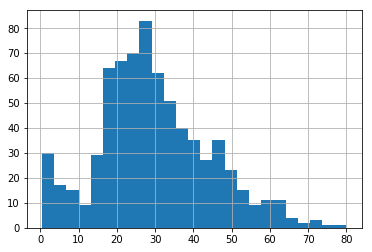

In [6]:
df['Age'].hist(bins = 25)

In [7]:
df['Age'].mean(), df['Age'].std()

(29.69911764705882, 14.526497332334044)

We suppose that the age is an important indicator of survival so instead of dropping the column altogether, we choose to fill the missing values with the average age.

In [8]:
df['Age'].fillna(df['Age'].mean(), inplace = True)

If we compute another repartition histogram, we now have a lot more values in the bin containing the mean. If this happens to be problematic during the model creation, we can always change our data cleaning strategy.

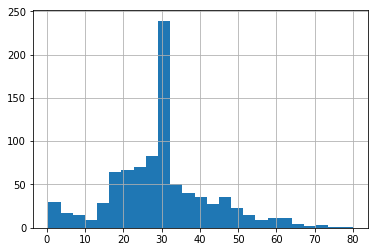

In [9]:
df['Age'].hist(bins = 25)

### Cabin

77% of the column is missing so we assume that we will not be able to use this information for the prediction and drop the column 

In [10]:
df.drop(['Cabin'], axis = 1, inplace = True)
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')


In [11]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Embarked

0.22% of the Embarked column is missing, let's look at the value repartition to get an idea of what is happening.

In [12]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [13]:
df['Embarked'].isna().sum()

2

As only 2 values are missing, we choose to replace them with the most common value, `S`.

In [14]:
df['Embarked'].fillna('S', inplace = True)

Now that we have cleaned our dataset, let's verify that no values are missing.

In [15]:
100 * df.isna().sum() / len(df)

PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Embarked       0.0
dtype: float64

## Training and validation set split

In order to properly evaluate the performance of our model, we have to use data that it has not seen during its training. For this purpose, we split our data in two parts: the training set, which we will use to train the models and the validation set, which we will use to evaluate the performances. Here we choose to hold 20% of the data to build the validation set.

In [16]:
df_train, df_val = train_test_split(df, test_size = 0.2)
print(f'Training set size: {len(df_train)}')
print(f'Validation set size: {len(df_val)}')

Training set size: 712
Validation set size: 179


# Model creation

## Very simple model

### Feature selection

When we do feature selection, we choose what values our model will be allowed to use to make its predictions. 

We are building a very simple model in order to have a very rough baseline so let's select a very small amount of features.

In [17]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
290,291,1,1,"Barber, Miss. Ellen ""Nellie""",female,26.000000,0,0,19877,78.8500,S
706,707,1,2,"Kelly, Mrs. Florence ""Fannie""",female,45.000000,0,0,223596,13.5000,S
358,359,1,3,"McGovern, Miss. Mary",female,29.699118,0,0,330931,7.8792,Q
472,473,1,2,"West, Mrs. Edwy Arthur (Ada Mary Worth)",female,33.000000,1,2,C.A. 34651,27.7500,S
533,534,1,3,"Peter, Mrs. Catherine (Catherine Rizk)",female,29.699118,0,2,2668,22.3583,C


In [18]:
X_train = df_train[['Age', 'Fare', 'Pclass']]
y_train = df_train['Survived']
X_val = df_val[['Age', 'Fare', 'Pclass']]
y_val = df_val['Survived']

In [19]:
X_train.head()

,Age,Fare,Pclass
290,26.000000,78.8500,1
706,45.000000,13.5000,2
358,29.699118,7.8792,3
472,33.000000,27.7500,2
533,29.699118,22.3583,3


In [20]:
y_train.head()

290    1
706    1
358    1
472    1
533    1
Name: Survived, dtype: int64

In [21]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
print(f'The training set accuracy is {100 * lr.score(X_train, y_train):5.2f}%')
print(f'The validation set accuracy is {100 * lr.score(X_val, y_val):5.2f}%')

The training set accuracy is 69.66%
The validation set accuracy is 73.18%


In [32]:
individuals = [
    [42, 100, 1],
    [20, 100, 1],
    [42, 200, 1],
    [42, 100, 3]
]
survival_proba = lr.predict_proba(individuals)

In [36]:
for individual, prediction in zip(individuals, survival_proba):
    print(f'Individual {individual}: {100 * prediction[1]:5.2f}% of survival')

Individual [42, 100, 1]: 64.53% of survival
Individual [20, 100, 1]: 77.37% of survival
Individual [42, 200, 1]: 77.08% of survival
Individual [42, 100, 3]: 27.55% of survival
